In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\tanzi\Personal Projects\cold_start_project_498r\data\clean_data.csv")
cluster_df = pd.read_csv(r"C:\Users\tanzi\Personal Projects\cold_start_project_498r\data\clustered_time_patterns.csv")

In [3]:
# Merge cluster info into invocation-level data
if 'time_bucket' in df.columns and 'time_bucket' in cluster_df.columns:
    df = df.merge(cluster_df[['hour', 'dayofweek', 'time_bucket', 'cluster', 'cold_start_ratio', 'total_invocations']],
                  on=['hour', 'dayofweek', 'time_bucket'], how='left')
else:
    df = df.merge(cluster_df[['hour', 'dayofweek', 'cluster', 'cold_start_ratio', 'total_invocations']],
                  on=['hour', 'dayofweek'], how='left')

In [4]:
# Use minimal non-leaky features for realistic performance
clf_features = ['hour', 'dayofweek', 'is_weekend', 'cluster',
                'prev_delay_1', 'prev_delay_2', 'prev_delay_3',
                'prev_cold_1', 'prev_cold_2', 'prev_cold_3']

X = df[clf_features]
y = df['Cold_Start']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# No scaling needed here
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [7]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 7, 10, None]
}

clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',       # handles class imbalance
    n_jobs=-1                      # (optional) use all CPU cores
)

gs = GridSearchCV(clf, param_grid, cv=5, scoring='f1', verbose=1)
gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             param_grid={'max_depth': [3, 7, 10, None],
                         'n_estimators': [100, 150, 200]},
             scoring='f1', verbose=1)

In [8]:

best_clf = gs.best_estimator_
y_pred = best_clf.predict(X_test_scaled)

In [9]:

print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      2063
           1       0.51      0.89      0.65        63

    accuracy                           0.97      2126
   macro avg       0.75      0.93      0.82      2126
weighted avg       0.98      0.97      0.98      2126


Confusion Matrix:
 [[2009   54]
 [   7   56]]


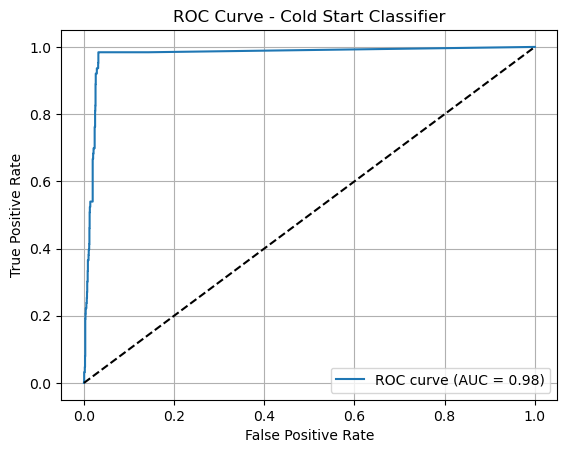

In [10]:
# ROC Curve
y_proba = best_clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Cold Start Classifier')
plt.legend()
plt.grid(True)
plt.savefig("ROC Curve - Cold Start Classifier.png", dpi=300)
plt.show()

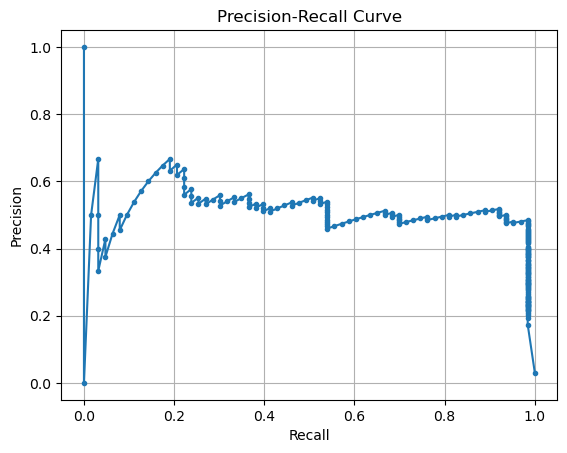

In [11]:

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.savefig("Precision-Recall Curve.png", dpi=300)
plt.show()

In [12]:
# Save classifier
joblib.dump(best_clf, '../models/cold_start_classifier.pkl')

['../models/cold_start_classifier.pkl']

In [13]:
# Error Analysis
errors = X_test_scaled.copy()
errors['true'] = y_test
errors['pred'] = y_pred
errors['proba'] = y_proba
print("\n Misclassified samples:")
print(errors[errors['true'] != errors['pred']].head())


 Misclassified samples:
      hour  dayofweek  is_weekend  cluster  prev_delay_1  prev_delay_2  \
5272     6          0           0        2          31.0          61.0   
3773    19          5           1        2         301.0          61.0   
7894    18          0           0        2          16.0          16.0   
8499     5          2           0        2         301.0         121.0   
5198    23          6           1        2         421.0          61.0   

      prev_delay_3  prev_cold_1  prev_cold_2  prev_cold_3  true  pred  \
5272         422.0          0.0          1.0          1.0     0     1   
3773         121.0          0.0          0.0          0.0     0     1   
7894          21.0          0.0          0.0          0.0     1     0   
8499         901.0          0.0          1.0          1.0     0     1   
5198          31.0          1.0          0.0          0.0     0     1   

         proba  
5272  0.728301  
3773  0.858825  
7894  0.217392  
8499  0.866787  
5198  

In [14]:
# --- Regression Task: Predict Delay ---
print("\n Regression: Predicting Delay")
reg_features = ['cold_start_ratio', 'total_invocations', 'cluster', 'anomaly_flag', 'cold_start_prob_est']
Xr = df[reg_features]
yr = df['Delay (s)']


 Regression: Predicting Delay


In [15]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=42)


In [16]:
scaler = StandardScaler()
Xr_train_scaled = Xr_train.copy()
Xr_test_scaled = Xr_test.copy()
Xr_train_scaled[['cold_start_ratio', 'total_invocations']] = scaler.fit_transform(Xr_train[['cold_start_ratio', 'total_invocations']])
Xr_test_scaled[['cold_start_ratio', 'total_invocations']] = scaler.transform(Xr_test[['cold_start_ratio', 'total_invocations']])

In [17]:
reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
reg.fit(Xr_train_scaled, yr_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
yr_pred = reg.predict(Xr_test_scaled)

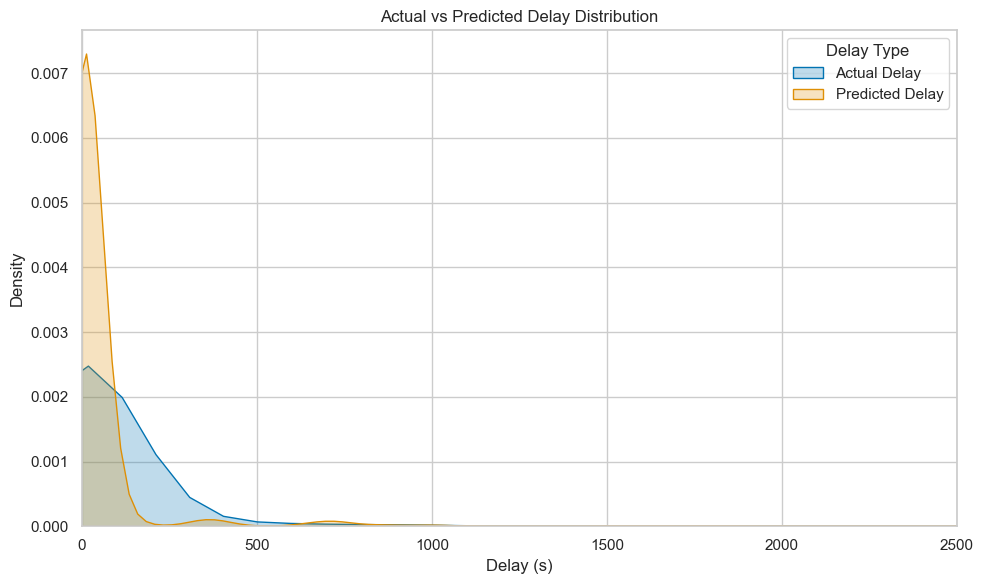

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set Seaborn theme and colorblind palette for accessibility
sns.set(style="whitegrid", palette="colorblind")

plt.figure(figsize=(10, 6))

# KDE plots with adjusted smoothing and fill
sns.kdeplot(yr_test, label='Actual Delay', fill=True, bw_adjust=1.5)
sns.kdeplot(yr_pred, label='Predicted Delay', fill=True, bw_adjust=1.5)

# Title and axis labels
plt.title('Actual vs Predicted Delay Distribution')
plt.xlabel('Delay (s)')
plt.ylabel('Density')

# Focus on meaningful range (adjust if your delays go beyond 2500s meaningfully)
plt.xlim(0, 2500)

# Show legend
plt.legend(title='Delay Type')

# Optimize layout and save
plt.tight_layout()
plt.savefig("fig_delay_distribution.png", dpi=300)
plt.show()


In [20]:
print("\n RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred)))
print(" MAE:", mean_absolute_error(yr_test, yr_pred))



 RMSE: 453.7290839721434
 MAE: 20.63526987020182


In [21]:
joblib.dump(reg, '../models/delay_predictor.pkl')

['../models/delay_predictor.pkl']